In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 3
setup_one_gpu(GPU)

Picking GPU 3


In [2]:
import sys
import time
import numpy as np
import os
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch, \
                                           plot_interpolations

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs
                                                  
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud

from tf_lab.point_clouds.gan import model_saver_id
from tf_lab.nips.shape_net import pc_loader as sn_pc_loader
from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset
from tf_lab.point_clouds.raw_gan import RawGAN
from tf_lab.point_clouds.raw_wgan import RawWGAN

from general_tools.notebook.tf import reset_tf_graph

/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
n_pc_samples = 2048
do_training = True
do_plotting = True
save_model = True
save_synthetics_sample = False
seed = 42

class_name = raw_input('Give me the class type.\n').lower()
syn_id = shape_net_category_to_synth_id()[class_name]
synthetic_data_out_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/NIPS/our_samples/'
experiment_name = 'raw_w_gan_' + class_name +'_' + str(n_pc_samples) +  '_pts'

Give me the class type.
chair


In [5]:
init_lr = None
max_epochs = 400
clamp = None
batch_size = 50
noise_params = {'mu':0, 'sigma': 1}

In [6]:
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
train_dir = osp.join(top_data_dir, 'OUT/models/nips/gan/raw_wgan')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

full_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
full_pclouds_path = osp.join(full_pclouds_path, syn_id)
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path, '.ply')
full_pclouds, full_model_ids, full_syn_ids = pio.load_crude_point_clouds(file_names=full_file_names,\
                                                                           n_threads=50, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )
train_data = PointCloudDataSet(full_pclouds)

6778 files containing complete point clouds were found.


In [7]:
clamp_list = [1, 10]
init_lr_list = [1e-3, 1e-4, 1e-5]

*==== STARTING: clamp: 1.000000, init_lr: 0.001000
1 (-2943.9910856063166, 13096.971944920442) 21.7839758396
INFO:tensorflow:/orions4-zfs/projects/lins2/Jingwei_Space/Git_Repos/tf_lab/notebooks/jingwei/c_1.000000_l_0.001000_/c_1.000000_l_0.001000_models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


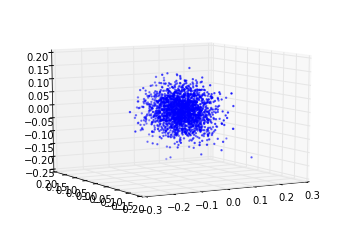

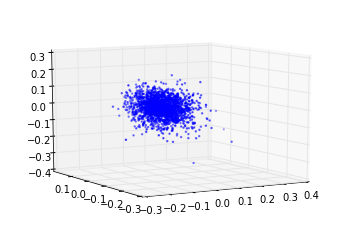

2 (-7318.7159089265042, 36737.500759548609) 21.4313299656
3 (-155052.02528935185, 473989.07609953702) 21.5906319618
4 (-1105195.6486111111, 4099913.9953703703) 21.614125967
5 (-2912095.6740740743, 15087863.851851853) 21.7148668766
6 (-3135042.651851852, 37593584.59259259) 21.7617409229
7 (-6235247.3481481485, 49682655.851851851) 21.7660160065
8 (-13814094.074074075, 79672879.111111104) 21.8699631691
9 (-3387533.8962962963, 74745848.0) 22.1737661362
10 (-3710386.6962962961, 73218105.925925925) 21.7922542095
11 (-4434065.0074074073, 92621785.481481478) 21.939811945
12 (-4770060.444444444, 108364618.37037037) 29.3815839291
13 (-5683951.1703703701, 120546649.48148148) 23.3354189396
14 (-5825593.3629629631, 130098408.5925926) 22.136480093
15 (-5516509.0370370373, 140230990.22222221) 22.0974388123
16 (-6170250.9037037035, 150653622.51851851) 21.5621190071
17 (-5914619.8518518517, 161094671.4074074) 22.2241258621
18 (-5548980.3851851849, 168346910.22222221) 22.2197499275
19 (-5988743.34814814

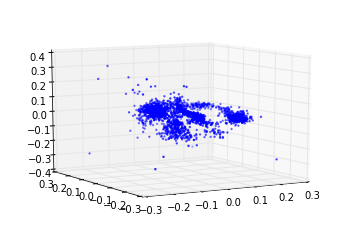

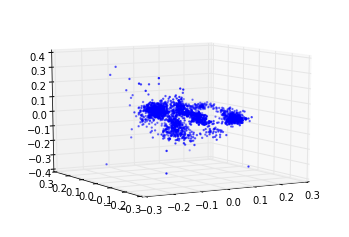

52 (-3983542.0444444446, 263528071.1111111) 22.2833120823
53 (-4478129.4222222222, 262835318.51851851) 21.6973719597
54 (-3930866.014814815, 261973607.7037037) 22.2912671566
55 (-3453664.5925925928, 260042577.18518519) 23.0018079281
56 (-3603191.7037037038, 262569786.07407406) 22.3980469704
57 (-3211953.777777778, 257902650.07407406) 22.1398420334
58 (-3323595.0222222223, 248352707.55555555) 22.4475069046
59 (-3502652.5629629628, 251038461.03703704) 22.4743130207
60 (-3360011.8518518517, 247825476.74074075) 22.4974918365
61 (-3131415.5851851851, 248188345.48148149) 22.4731459618
62 (-3212420.0296296296, 247691074.96296296) 22.3227798939
63 (-3372611.0814814814, 244751116.44444445) 23.4847528934
64 (-3009597.1555555556, 249717464.2962963) 22.5179839134
65 (-2788674.1333333333, 246120735.4074074) 21.8864629269
66 (-3254930.6074074074, 248572128.0) 22.5716969967
67 (-2316825.3629629631, 249890628.14814815) 22.6559569836
68 (-3132066.4888888891, 249949601.77777779) 21.7176492214
69 (-29136

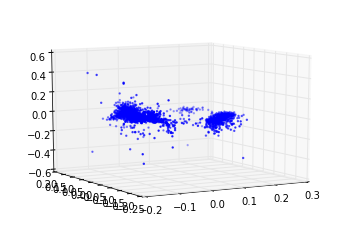

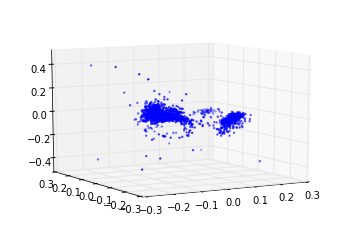

102 (-1700279.9407407406, 212679982.81481481) 21.4822390079
103 (-1514824.4148148149, 212303380.74074075) 21.4560480118
104 (-1645276.325925926, 212417556.74074075) 21.475851059
105 (-1733702.6370370369, 212886184.8888889) 21.5059809685
106 (-1787294.2222222222, 216862323.55555555) 21.3945708275
107 (-1851230.3407407408, 215813454.22222221) 21.6583268642
108 (-1254438.874074074, 219005026.96296296) 21.4892570972
109 (-1745973.3333333333, 219471938.96296296) 21.4854979515
110 (-1512753.6592592592, 217256619.85185185) 21.5307791233
111 (-1495638.6370370369, 214719495.7037037) 21.5141620636
112 (-1703071.4074074074, 211524775.7037037) 21.4998128414
113 (-1374133.8074074073, 214801449.48148149) 21.5354850292
114 (-1120244.0296296296, 214968964.14814815) 21.5095541477
115 (-1405320.2962962964, 206667927.1111111) 21.5169799328
116 (-1732356.0296296296, 200851887.4074074) 21.6997628212
117 (-1225546.9037037038, 201423706.07407406) 21.5398769379
118 (-1010256.1185185185, 202925166.81481481) 21

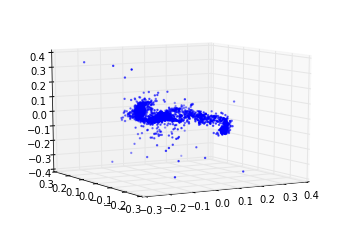

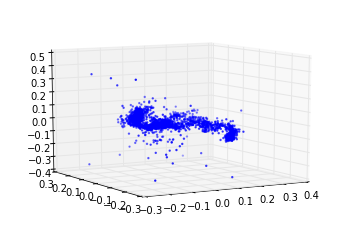

152 (-939192.53333333333, 173711402.07407406) 21.5492551327
153 (-1223364.2666666666, 171636855.1111111) 21.6192250252
154 (-1067800.1777777779, 168174757.33333334) 21.650220871
155 (-931766.16296296299, 171955597.03703704) 21.8262140751
156 (-1122023.348148148, 168473947.85185185) 24.4786331654
157 (-850599.34814814816, 169763970.96296296) 23.5434660912
158 (-1048339.5555555555, 166193624.8888889) 22.0989129543
159 (-1209791.0518518519, 168308338.96296296) 22.0373489857
160 (-778777.00740740739, 170954045.03703704) 22.9894900322
161 (-1101575.7037037036, 170095900.44444445) 22.9019520283
INFO:tensorflow:/orions4-zfs/projects/lins2/Jingwei_Space/Git_Repos/tf_lab/notebooks/jingwei/c_1.000000_l_0.001000_/c_1.000000_l_0.001000_models.ckpt-161 is not in all_model_checkpoint_paths. Manually adding it.
162 (-761953.06666666665, 174743972.14814815) 22.3467941284
163 (-1178176.3555555556, 178073581.62962964) 22.5013728142
164 (-1139837.8666666667, 174432836.74074075) 21.5421490669
165 (-101088

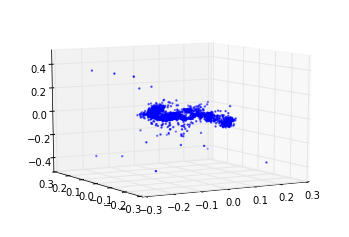

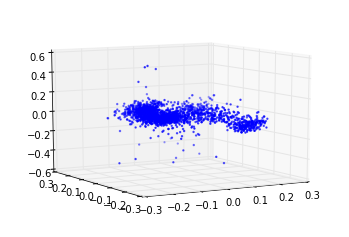

202 (-599221.68888888892, 149074925.92592594) 22.1877520084
203 (-470688.88888888888, 150891699.85185185) 21.865530014
204 (-602791.52592592593, 154603054.81481481) 22.4491729736
205 (-469609.06666666665, 143877305.77777779) 21.9923849106
206 (-785818.72592592589, 146778245.92592594) 22.115445137
207 (-906467.97037037031, 141765491.25925925) 22.167206049
208 (-641227.19999999995, 135755263.7037037) 22.2722918987
209 (-795378.07407407404, 141314652.14814815) 21.7242019176
210 (-680840.94814814813, 136733680.5925926) 21.913285017
211 (-727905.30370370368, 135477609.77777779) 21.6888859272
212 (-774764.26666666672, 132816799.7037037) 22.5014491081
213 (-832616.0, 137286605.62962964) 21.9351408482
214 (-514777.77777777775, 129115308.44444445) 21.7438941002
215 (-572929.59999999998, 129565395.55555555) 21.788132906
216 (-896952.41481481481, 139544165.03703704) 22.2102880478
217 (-905943.58518518519, 141987730.96296296) 22.0635249615
218 (-887299.37777777773, 141389698.66666666) 21.856591939

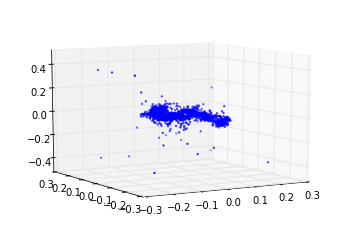

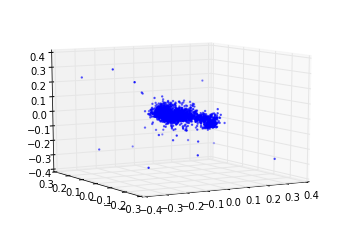

252 (-846683.08148148144, 124447755.85185185) 21.341604948
253 (-450587.02222222224, 118284280.2962963) 22.1844830513
254 (-432543.82222222222, 106343213.62962963) 21.7735168934
255 (-767408.0, 113871619.55555555) 21.5181398392
256 (-765856.47407407407, 112855668.44444445) 21.9838609695
257 (-700912.29629629629, 105141684.44444445) 22.0506629944
258 (-417817.59999999998, 80876285.481481478) 21.4615600109
259 (-517162.81481481483, 91012788.740740746) 21.8225109577
260 (-373220.11851851852, 72845966.074074075) 21.6842029095
261 (-703345.24444444443, 98374106.074074075) 21.4336521626
262 (-412605.9259259259, 99193365.925925925) 21.6777989864
263 (-493080.91851851851, 73624554.074074075) 21.6208450794
264 (-292646.84444444446, 84827268.740740746) 21.645742178
265 (-394049.68888888886, 79676354.222222224) 21.6238968372
266 (-457757.68888888886, 87199229.185185179) 21.8875408173
267 (-228241.74814814815, 86654613.03703703) 21.4790458679
268 (-389877.62962962961, 84149460.296296299) 21.670847

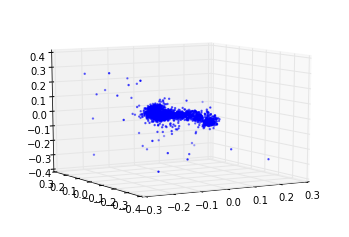

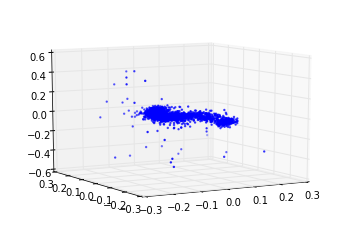

302 (-661879.34814814816, 76936060.148148149) 21.6964018345
303 (-563840.05925925926, 74904362.074074075) 21.5548899174
304 (-559407.1407407407, 83095754.074074075) 21.5566539764
305 (-557968.8592592593, 74784045.481481478) 21.5832710266
306 (-593924.94814814813, 84749959.703703701) 21.7362320423
307 (-772238.69629629632, 79382147.259259254) 21.7238900661
308 (-756666.40000000002, 84625982.370370373) 21.5636529922
309 (-648686.04444444447, 85847468.740740746) 21.7846457958
310 (-687222.40000000002, 87417485.03703703) 21.9775598049
311 (-579707.34814814816, 81861809.925925925) 21.6366980076
312 (-712385.27407407411, 79041174.518518522) 21.8304319382
313 (-671210.5777777778, 82820787.703703701) 21.5140330791
314 (-694430.28148148151, 87494533.925925925) 21.6193759441
315 (-612854.04444444447, 79543467.407407403) 21.6763901711
316 (-699739.08148148144, 82042941.333333328) 21.4625878334
317 (-1085008.0888888889, 82318944.740740746) 22.0708379745
318 (-745133.8666666667, 81149756.0) 21.7940

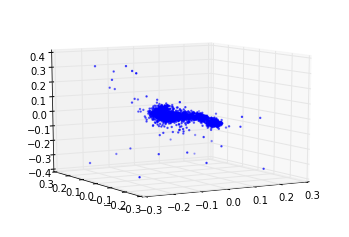

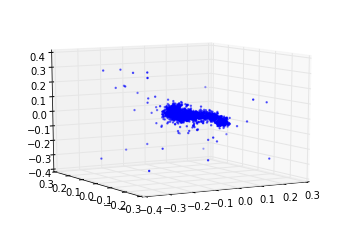

352 (-649282.63703703706, 51916592.296296299) 21.7806518078
353 (-1208662.1037037037, 53742706.740740739) 21.8751950264
354 (-882411.25185185182, 41690383.40740741) 21.8872020245
355 (-599343.20740740746, 45980069.888888888) 21.5584280491
356 (-717618.05046296294, 37597624.962962963) 21.6843090057
357 (-942411.1555555556, 36636222.666666664) 21.6205639839
358 (-967073.63703703706, 39117499.851851851) 21.7004330158
359 (-895808.42962962959, 41373332.0) 21.8421301842
360 (-1099067.4777777777, 35121435.388888888) 22.0006849766
361 (-824838.6555555556, 34541542.833333336) 21.6699380875
INFO:tensorflow:/orions4-zfs/projects/lins2/Jingwei_Space/Git_Repos/tf_lab/notebooks/jingwei/c_1.000000_l_0.001000_/c_1.000000_l_0.001000_models.ckpt-361 is not in all_model_checkpoint_paths. Manually adding it.
362 (-855830.11851851852, 42378872.074074075) 21.5378799438
363 (-831090.08518518519, 36733038.074074075) 21.517539978
364 (-923158.42500000005, 35209523.601851851) 21.6502230167
365 (-868079.7407407

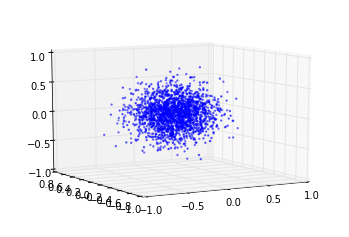

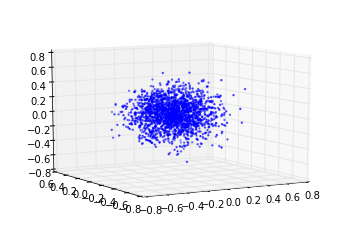

2 (-50.944063334994844, 105.50276445459437) 21.5255079269
3 (-158.41586354573568, 400.61390007866754) 21.6487789154
4 (-356.62584771050348, 1110.8938327365452) 21.5887930393
5 (-735.88152036313659, 2485.3164514612267) 21.7833678722
6 (-1422.4433955439815, 4760.7246817129626) 21.6399440765
7 (-2568.0022316261575, 8151.4716796875) 21.6235539913
8 (-4384.9798538773148, 12402.358977141204) 21.480702877
9 (-7330.7081380208338, 17360.561342592591) 21.8662650585
10 (-11766.553327546297, 23883.283998842591) 21.9433910847
11 (-17956.999197048612, 33927.409649884263) 21.525042057
12 (-26255.080859375001, 48425.083043981482) 21.7881519794
13 (-36716.295457175926, 67682.596932870365) 21.5851271152
14 (-50241.303356481483, 91842.492766203708) 21.8213899136
15 (-66718.088454861107, 124586.96932870371) 21.7999870777
16 (-85776.498206018514, 164596.85185185185) 21.9043850899
17 (-105895.84704861112, 213552.2008101852) 22.154925108
18 (-127238.84363425926, 272549.22453703702) 21.7498831749
19 (-147429.

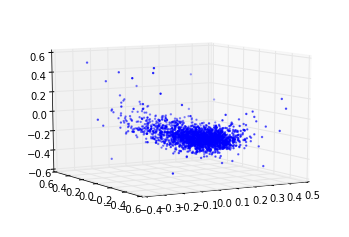

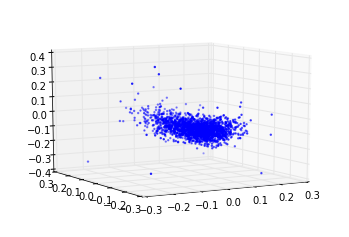

52 (-91400.981481481474, 3108556.4537037038) 21.600055933
53 (-48836.920370370368, 2834182.3703703703) 21.6743679047
54 (-118858.67592592593, 2522654.8796296297) 21.9261000156
55 (-163514.47962962964, 2478087.7592592593) 21.8975119591
56 (-157742.2888888889, 2412101.5370370368) 22.0817070007
57 (-188852.7074074074, 2464262.25) 21.8867630959
58 (-245400.37037037036, 2502572.722222222) 22.1333429813
59 (-318149.4574074074, 2627277.8333333335) 21.7639219761
60 (-400221.15555555554, 2975737.611111111) 21.9581639767
61 (-480947.74814814812, 3285979.5648148148) 22.2088749409
62 (-573703.89259259263, 3725325.9629629632) 21.8196229935
63 (-661873.89629629627, 4255876.888888889) 21.7927439213
64 (-749686.02222222218, 4804081.611111111) 21.8926858902
65 (-831229.47777777782, 5361854.777777778) 21.9294040203
66 (-910240.4444444445, 6026578.5370370373) 21.7145740986
67 (-988913.99629629625, 6832201.1296296297) 21.585860014
68 (-1033243.7518518518, 7547666.5) 21.4763529301
69 (-1027256.4814814815, 

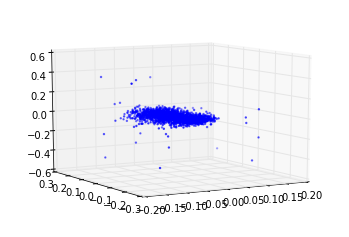

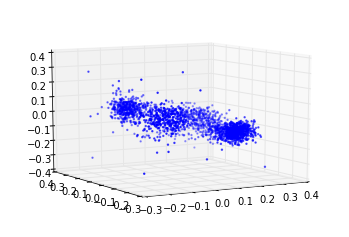

102 (-946246.96296296292, 27066509.333333332) 21.8354239464
103 (-868812.08888888895, 27505259.629629631) 21.722440958
104 (-899210.63703703706, 27544428.370370369) 21.7351191044
105 (-857922.50370370375, 27447735.703703705) 22.1627538204
106 (-843110.1481481482, 28380220.888888888) 28.4814457893
107 (-805144.77037037036, 28257789.185185187) 30.2688381672
108 (-750019.33333333337, 28105783.777777776) 31.7804961205
109 (-696822.97777777782, 28833122.666666668) 30.5801620483
110 (-589486.96296296292, 28675905.407407407) 29.6866841316
111 (-523607.97037037037, 29417792.444444444) 31.4134268761
112 (-437588.01481481484, 30374048.518518519) 31.5561418533
113 (-368891.97037037037, 29747600.962962963) 29.6314909458
114 (-404206.82962962962, 30540763.481481481) 31.3738470078
115 (-396307.25925925927, 30430440.740740743) 31.4154520035
116 (-382394.14814814815, 30741302.148148149) 29.8490760326
117 (-372852.88888888888, 30785026.296296295) 31.6847419739
118 (-278828.32592592592, 30308382.7407407

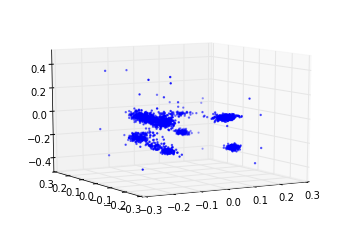

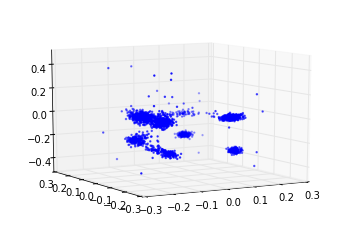

152 (-146414.68148148147, 30104761.851851851) 30.0430390835
153 (-152123.60000000001, 30365763.259259257) 30.237716198
154 (-181191.92592592593, 30337541.333333332) 31.2694430351
155 (-171256.59259259258, 30378044.814814813) 30.9198188782
156 (-146329.70370370371, 30480487.555555556) 29.8811759949
157 (-169609.17037037038, 30540378.814814813) 31.0530512333
158 (-151371.57037037038, 30305462.296296295) 31.3777580261
159 (-149059.80740740741, 30550324.740740743) 30.2474379539
160 (-163795.30370370371, 30702846.074074075) 30.4563629627
161 (-174285.70370370371, 30801808.814814813) 31.7010278702
INFO:tensorflow:/orions4-zfs/projects/lins2/Jingwei_Space/Git_Repos/tf_lab/notebooks/jingwei/c_1.000000_l_0.000100_/c_1.000000_l_0.000100_models.ckpt-161 is not in all_model_checkpoint_paths. Manually adding it.
162 (-175203.24444444446, 30586297.925925925) 30.1049289703
163 (-154371.14074074075, 30886499.259259257) 32.4360051155
164 (-169376.91851851851, 30795191.111111112) 31.5039200783
165 (-178

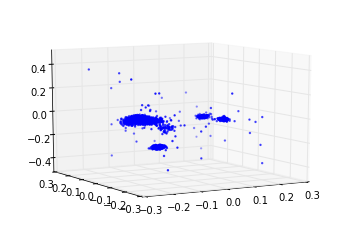

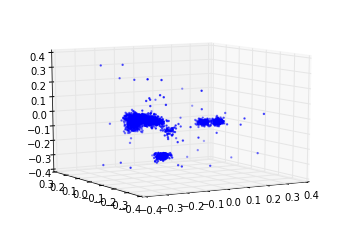

202 (-213491.52592592593, 34143364.296296299) 31.2906658649
203 (-222914.57777777777, 33915026.074074075) 30.5657689571
204 (-203830.97777777776, 34243150.814814813) 32.9581718445
205 (-200595.14074074075, 34637794.074074075) 31.0339808464
206 (-195118.85925925925, 34660142.222222224) 30.9655578136
207 (-207495.11111111112, 34879976.148148149) 31.4441111088
208 (-227435.30370370371, 34248126.518518515) 31.4897758961
209 (-181593.21481481483, 34367756.518518515) 30.2307040691
210 (-190183.54074074075, 34270435.925925925) 30.7921340466
211 (-194915.3925925926, 34635290.222222224) 31.8277130127
212 (-221766.26666666666, 34522063.851851851) 30.6216790676
213 (-194344.93333333332, 34777118.148148149) 30.4810140133
214 (-186834.42962962962, 34760666.074074075) 31.5909001827
215 (-176570.93333333332, 34826915.40740741) 30.7135429382
216 (-184027.58518518519, 35185218.666666664) 30.2207701206
217 (-198416.0, 35379302.962962963) 31.6819489002
218 (-195293.36296296297, 35716417.629629627) 31.510

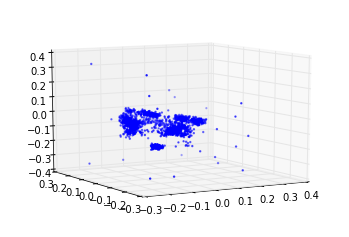

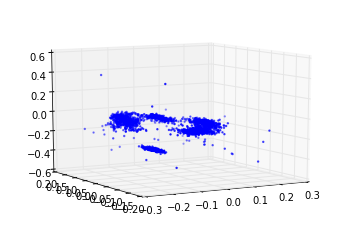

252 (-179011.05185185187, 39663499.851851851) 31.6657369137
253 (-178242.45925925925, 40080808.888888888) 30.9501509666
254 (-186029.48148148149, 40166457.481481485) 31.9618191719
255 (-165483.61481481482, 39798686.814814813) 31.8529891968
256 (-164069.54074074075, 39731002.370370373) 30.9086921215
257 (-155004.82962962962, 40139076.0) 30.7285730839
258 (-149304.97777777776, 39753978.518518515) 31.3078899384
259 (-160105.45185185186, 40003532.444444448) 31.0852148533
260 (-152343.58518518519, 39824736.740740739) 30.4696221352
261 (-156559.70370370371, 40168192.444444448) 31.3147900105
262 (-168132.2074074074, 39738458.370370373) 31.7880690098
263 (-182966.66666666666, 40146675.40740741) 30.0384821892
264 (-168760.88888888888, 41151722.370370373) 31.9241158962
265 (-169832.77037037036, 40523297.777777776) 32.320980072
266 (-152292.0, 40091238.222222224) 30.5274548531
267 (-165464.41481481481, 40090212.444444448) 31.9648659229
268 (-141546.22222222222, 39247262.962962963) 31.4253540039
2

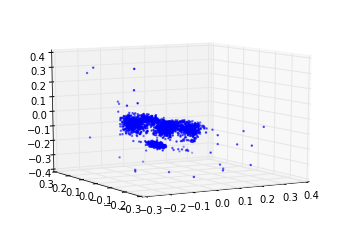

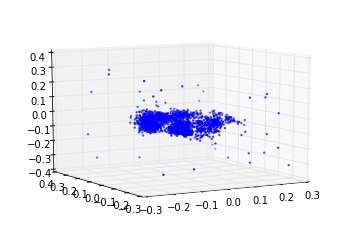

302 (-138494.75555555554, 41098192.296296299) 33.1966869831
303 (-132355.4962962963, 41279013.185185187) 31.4943099022
304 (-131731.40740740742, 41386910.666666664) 31.8826310635
305 (-129797.06666666667, 41616172.888888888) 32.7310979366
306 (-124051.02222222222, 41942188.444444448) 31.3713748455
307 (-131875.37777777779, 41892666.666666664) 32.3041789532
308 (-129811.46666666666, 42528730.518518515) 33.2636768818
309 (-124812.50370370371, 42221404.444444448) 31.0433499813
310 (-133073.09629629631, 41943682.666666664) 32.4648389816
311 (-133951.14074074075, 41808782.074074075) 32.325576067
312 (-130091.43703703703, 41483234.074074075) 31.4511990547
313 (-123768.71111111112, 41885253.333333336) 33.1449661255
314 (-132058.22222222222, 42082481.481481485) 31.8762431145
315 (-128949.03703703704, 42271427.40740741) 33.2859530449
316 (-129691.05185185185, 41826410.518518515) 33.037227869
317 (-124285.09629629629, 42418169.037037037) 31.0578200817
318 (-118632.35555555555, 42307744.444444448

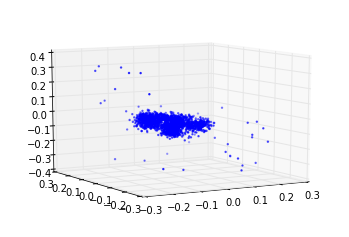

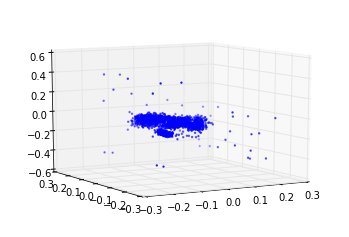

352 (-114829.09629629629, 43940363.111111112) 32.2453420162
353 (-116093.45185185185, 43978789.925925925) 32.0644879341
354 (-116651.25925925926, 43205121.925925925) 30.4330301285
355 (-104026.39999999999, 43664569.777777776) 32.4254190922
356 (-103058.72592592593, 43962056.444444448) 31.8399748802
357 (-116327.94074074074, 43053128.888888888) 30.6466531754
358 (-117268.88888888889, 43615519.555555552) 32.498319149
359 (-101884.02962962963, 43517807.555555552) 32.0287458897
360 (-106147.46666666666, 43402128.888888888) 30.3951439857
361 (-106642.96296296296, 43803453.777777776) 32.4974689484
INFO:tensorflow:/orions4-zfs/projects/lins2/Jingwei_Space/Git_Repos/tf_lab/notebooks/jingwei/c_1.000000_l_0.000100_/c_1.000000_l_0.000100_models.ckpt-361 is not in all_model_checkpoint_paths. Manually adding it.
362 (-106476.41481481481, 42652378.518518515) 30.4534010887
363 (-100202.66666666667, 43099382.074074075) 31.840528965
364 (-95146.814814814818, 42821955.259259261) 32.3431792259
365 (-9797

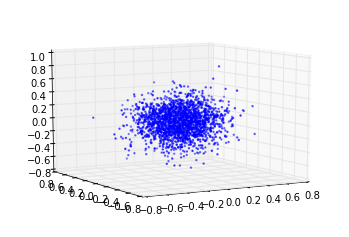

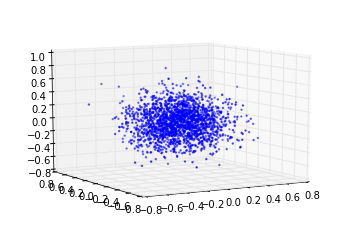

2 (-1.991154275117097, 4.2888981766170922) 32.2749869823
3 (-3.8478345040921811, 8.2087818428322112) 31.6240129471
4 (-5.7989716777095088, 12.610886114614981) 30.4363479614
5 (-7.5019326033415616, 17.284586270650227) 31.8795380592
6 (-9.1874476185551401, 22.535148055465132) 32.0130808353
7 (-10.82457324133979, 28.601314403392649) 30.9143259525
8 (-12.739439801816587, 35.646685141104236) 31.9884059429
9 (-14.950370732060184, 43.465800108732999) 32.2183289528
10 (-17.146824222140843, 52.542880729392721) 30.8916578293
11 (-20.213186362937645, 62.62359407212999) 32.29043293
12 (-23.435832270869501, 73.519674513075088) 32.490350008
13 (-27.035984039306641, 85.368742766203709) 31.0132219791
14 (-31.373128029152198, 98.423358775951243) 32.5704939365
15 (-35.663522677951391, 112.72286252622251) 31.9961009026
16 (-40.921086742259838, 129.36305010760273) 30.9542469978
17 (-46.55479414198134, 146.93029163501882) 32.4766299725
18 (-53.408494511357063, 165.10642101146556) 31.5816018581
19 (-60.0020

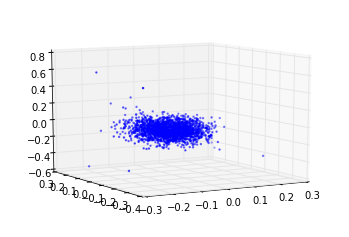

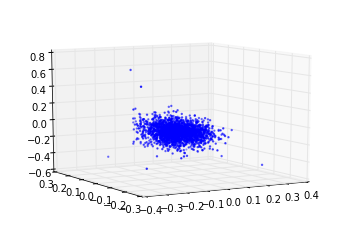

52 (-825.33865288628476, 2953.5302824797454) 31.8091189861
53 (-874.26669017650465, 3138.3019657841437) 32.0744009018
54 (-913.35663881655091, 3317.2796223958335) 30.3799271584
55 (-971.21693250868054, 3502.380787037037) 31.7559468746
56 (-1018.6149703414352, 3689.0664514612267) 32.0896680355
57 (-1071.0040346498843, 3864.223804615162) 30.3329408169
58 (-1119.7577546296295, 4069.5716507523148) 31.5389080048
59 (-1178.3328233506945, 4279.8009801793978) 32.259595871
60 (-1250.0482168692129, 4509.3233326099535) 30.7694900036
61 (-1302.517135054977, 4739.9837782118057) 31.7539339066
62 (-1363.3213722511573, 4961.458170572917) 32.0039060116
63 (-1428.8768174913193, 5200.287272135417) 30.7727351189
64 (-1492.5578812210649, 5438.138346354167) 31.916312933
65 (-1540.2957881221064, 5677.0850694444443) 32.2928960323
66 (-1606.3940321180555, 5897.4636140046296) 31.0413281918
67 (-1677.446091941551, 6166.857747395833) 31.7019190788
68 (-1738.6842086226852, 6425.8259006076387) 32.2076339722
69 (-18

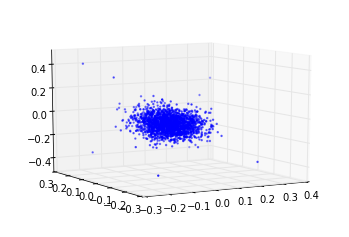

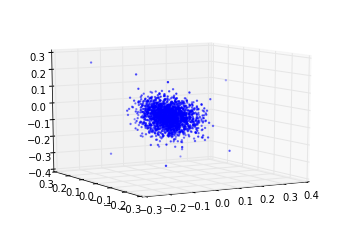

102 (-9382.8841073495369, 16742.762152777777) 30.2462148666
103 (-9892.7809317129631, 17435.022497106482) 32.2557859421
104 (-10377.73587962963, 18055.719690393518) 32.0134339333
105 (-10794.828580729167, 18892.189814814814) 30.3088288307
106 (-11291.327524594908, 19562.017216435186) 31.8247778416
107 (-11823.80611255787, 20432.238932291668) 32.4912040234
108 (-12279.717918113425, 21239.825376157409) 30.3843259811
109 (-12798.121151620371, 22238.576895254631) 31.8452308178
110 (-13401.194661458334, 23100.884186921296) 32.355645895
111 (-13902.743337673612, 24252.726924189814) 30.2830460072
112 (-14399.40931712963, 25357.294415509259) 31.6038358212
113 (-14987.27134693287, 26299.809027777777) 32.4464859962
114 (-15499.785083912036, 27074.119646990741) 30.7074780464
115 (-16082.075361689815, 28028.101128472223) 31.3209228516
116 (-16623.760648148149, 29360.455439814814) 32.6670100689
117 (-17216.489134837964, 30543.535373263891) 30.7398471832
118 (-17749.989937789353, 31769.351417824073)

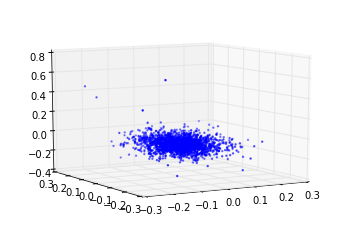

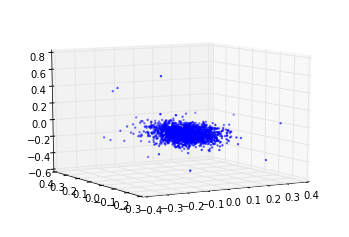

152 (-40966.226157407407, 92210.549479166672) 31.9877309799
153 (-41627.699247685188, 95038.749710648146) 30.8727228642
154 (-42165.654282407406, 97705.366608796292) 30.9575800896
155 (-42679.788454861111, 100522.26070601853) 32.0412659645
156 (-43049.349016203705, 102700.30005787036) 31.573882103
157 (-43220.56976273148, 105849.95891203704) 31.2324531078
158 (-43869.838194444441, 110171.36024305556) 31.9351739883
159 (-44394.85211226852, 112698.65335648147) 31.3581390381
160 (-44296.721064814818, 116965.671875) 31.1656761169
161 (-44976.113946759258, 119081.56770833333) 31.9111850262
INFO:tensorflow:/orions4-zfs/projects/lins2/Jingwei_Space/Git_Repos/tf_lab/notebooks/jingwei/c_1.000000_l_0.000010_/c_1.000000_l_0.000010_models.ckpt-161 is not in all_model_checkpoint_paths. Manually adding it.
162 (-45499.400028935182, 121642.09172453704) 29.4422860146
163 (-46409.017910879629, 122971.65914351853) 30.9669499397
164 (-46596.110966435182, 126606.6495949074) 31.3693549633
165 (-46502.24383

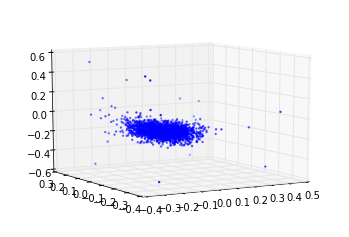

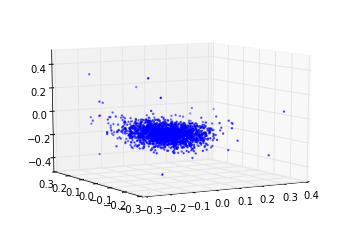

202 (-11980.674189814816, 224097.26388888888) 30.1370959282
203 (-9679.4172453703704, 219511.8570601852) 30.6835920811
204 (-9759.4047453703697, 214836.92129629629) 31.3651068211
205 (-7534.2682870370372, 216809.39583333334) 30.3280029297
206 (-5482.7857638888891, 212026.64120370371) 30.387237072
207 (-4216.0986111111115, 203386.49942129629) 31.3054630756
208 (-1955.2525462962963, 203755.39583333334) 30.8797821999
209 (-1280.538773148148, 198229.30960648149) 29.6064870358
210 (-218.67013888888889, 195022.92881944444) 31.9118740559
211 (1706.8370370370371, 192251.87152777778) 31.085078001
212 (5645.3086805555558, 186924.61226851851) 30.1298391819
213 (3471.3325231481481, 183908.13368055556) 31.9640629292
214 (7211.8809027777779, 178836.13773148149) 31.2426538467
215 (9871.6372685185179, 174232.1226851852) 29.791218996
216 (10644.268287037037, 173166.42476851851) 31.8656978607
217 (8044.7003472222223, 165466.00462962964) 31.4604959488
218 (8625.445543981481, 155453.44270833334) 30.157309

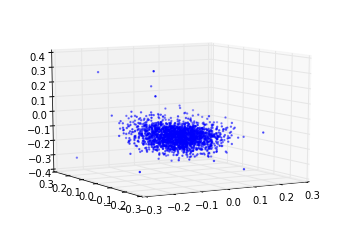

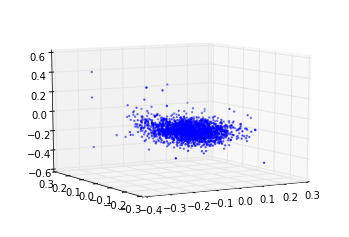

252 (221.80095486111111, 39320.089554398146) 31.0919790268
253 (-851.5252604166667, 38651.024305555555) 29.9258129597
254 (-2024.9856481481481, 36888.268084490737) 31.1361801624
255 (-2778.1105758101853, 33804.964120370372) 31.1946730614
256 (-3405.039525462963, 30142.238642939814) 30.4275860786
257 (-3647.0922887731481, 27560.981481481482) 30.9827818871
258 (-3795.6799334490743, 26342.249927662036) 31.7173411846
259 (-3937.6319010416669, 26681.93330439815) 30.3732609749
260 (-4307.3359664351856, 27903.672381365741) 31.2325060368
261 (-4489.8780526620367, 30620.075737847223) 31.3040549755
262 (-4513.446846064815, 31802.9453125) 30.1574780941
263 (-4450.2917245370372, 33821.792824074073) 29.9962999821
264 (-4126.3700520833336, 34475.970920138891) 31.5578570366
265 (-3910.327126736111, 34571.656828703701) 30.9746448994
266 (-3823.0012152777776, 34230.661313657409) 30.2125730515
267 (-3950.465306712963, 32831.139105902781) 31.722370863
268 (-4430.6144241898146, 32060.268301504631) 30.8994

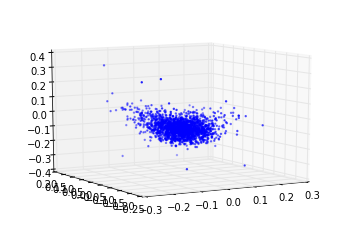

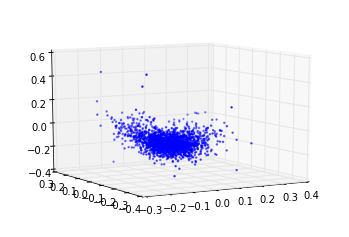

302 (-4418.6161458333336, 67757.980034722219) 31.3077378273
303 (-4958.8599826388891, 63485.305555555555) 30.9484248161
304 (-5531.0463541666668, 59752.339265046299) 29.4785680771
305 (-5889.2430844907403, 58280.309895833336) 30.4432840347
306 (-5934.6836516203703, 57413.148148148146) 31.0877861977
307 (-5931.7581597222224, 60294.293402777781) 29.9291100502
308 (-5508.2339699074073, 62800.038483796299) 29.7793400288
309 (-5371.3069155092589, 64246.625868055555) 30.963932991
310 (-5263.9495370370369, 64184.106915509263) 30.7713119984
311 (-5342.0508680555558, 62605.675925925927) 29.5578570366
312 (-5627.8440682870369, 59792.411458333336) 31.1181228161
313 (-5951.4132233796299, 57179.504918981482) 31.6032278538
314 (-6164.8848090277779, 55534.211516203701) 29.8783009052
315 (-6087.8756365740737, 57022.264901620372) 31.1364841461
316 (-6068.3849247685184, 61567.618489583336) 31.1266670227
317 (-6129.8635127314819, 67210.331597222219) 30.212061882
318 (-6276.0013888888889, 71947.7288773148

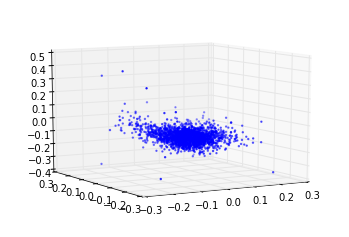

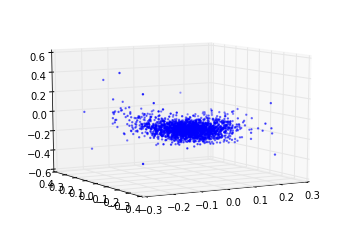

352 (-9933.0447916666672, 124315.52430555556) 31.5874450207
353 (-9870.9905092592599, 127074.72337962964) 31.3525528908
354 (-9996.8321759259252, 128223.04484953704) 29.560988903
355 (-10227.813831018519, 130106.26851851853) 31.1549320221
356 (-10432.140682870371, 133060.00868055556) 31.283023119
357 (-10545.574189814815, 135207.18692129629) 30.2357158661
358 (-10668.576793981481, 136994.75347222222) 30.9203808308
359 (-10779.996585648149, 138504.04976851851) 31.2062549591
360 (-10955.40011574074, 139412.36631944444) 29.782720089
361 (-11129.102719907407, 141438.01909722222) 30.9385430813
INFO:tensorflow:/orions4-zfs/projects/lins2/Jingwei_Space/Git_Repos/tf_lab/notebooks/jingwei/c_1.000000_l_0.000010_/c_1.000000_l_0.000010_models.ckpt-361 is not in all_model_checkpoint_paths. Manually adding it.
362 (-11267.383854166666, 144070.39872685185) 30.7559499741
363 (-11454.801736111111, 148394.20833333334) 29.7593500614
364 (-11549.604861111111, 149436.40104166666) 31.1149728298
365 (-11650.

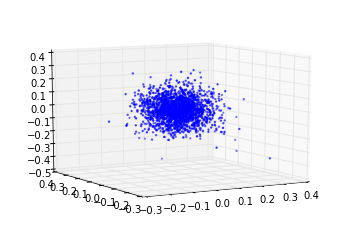

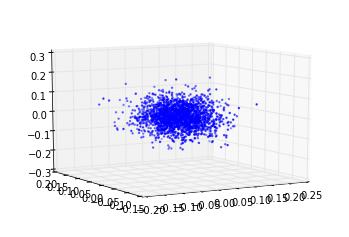

2 (-12791.132233796296, 105600.48133680556) 30.4914610386
3 (-568941.83767361112, 2140026.5601851852) 29.345539093
4 (-8436729.5, 34374938.166666664) 30.725507021
5 (-40442849.600000001, 181695772.14814815) 31.1532661915
6 (-140091123.43703705, 708013365.33333337) 29.7391438484
7 (-425254469.21481484, 2198395306.6666665) 30.2264158726
8 (-370167690.42962962, 5300870106.0740738) 31.1139090061
9 (-827379708.20740736, 11822495440.592592) 30.0521130562
10 (-1353940043.8518519, 15273457474.370371) 30.0266070366
11 (-16217876.859259259, 10386679637.333334) 31.2252879143
12 (-49727286.992592596, 6319028432.5925922) 30.7218089104
13 (-142207761.06666666, 8653608865.1851845) 29.8887639046
14 (-167381189.21481481, 12040336611.555555) 31.2507240772
15 (-188503297.89629629, 13321171512.888889) 31.1248748302
16 (-297029639.58518517, 16898505652.148148) 29.7549688816
17 (-455883540.85925925, 23272517404.444443) 30.9128007889
18 (-911445591.22962964, 32245704628.148148) 31.1746149063
19 (-721558945.1

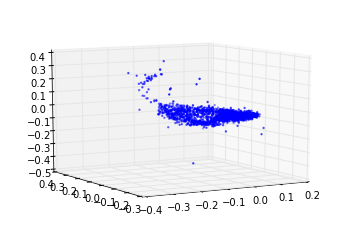

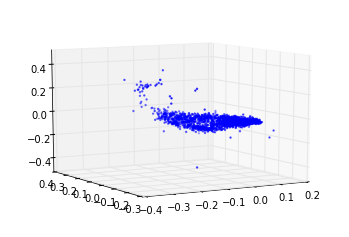

52 (11309937823.288889, 2309710739076.7407) 31.234183073
53 (-517681000.2962963, 2092665701565.6296) 31.200838089
54 (-14018251373.985186, 1861045428527.4075) 29.5927288532
55 (-8651191819.3777771, 1855900342802.9629) 31.1062450409
56 (-9766363075.3185177, 2009675508394.6667) 31.0895309448
57 (-8049035400.5333338, 2290649685712.5928) 30.1502199173
58 (-12443501878.992592, 2323632580683.8521) 30.4223670959
59 (-7436994211.0814819, 2567630642896.5928) 31.6273088455
60 (-11823482773.807407, 2534136630234.0742) 30.4672679901
61 (-22535379839.051853, 2860307758497.1851) 30.307076931
62 (-33467475922.488888, 3005910691688.2964) 31.8504450321
63 (-13381742440.296297, 3063203340591.4072) 30.5976819992
64 (-26181752392.059258, 3204814810984.2964) 30.246694088
65 (-21017546660.977779, 3279394895492.7407) 31.454941988
66 (-25611412487.585186, 3341312385934.2222) 30.7739751339
67 (-21712511764.859261, 3530313646686.8149) 29.8928849697
68 (-19949719582.34074, 3824371416481.1851) 31.0771539211
69 (-

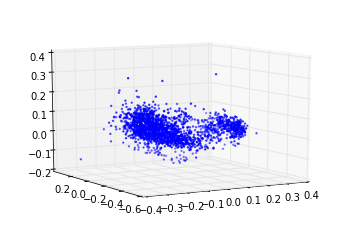

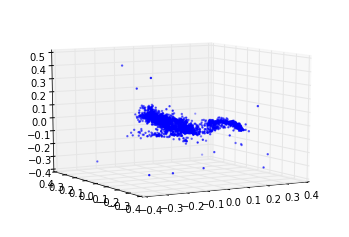

102 (-219105734018.84445, 24066686675019.852) 31.264496088
103 (-136410339252.14815, 25605374864649.48) 31.7234799862
104 (-172452863453.86667, 26100242462947.555) 29.8700349331
105 (-194739049206.51852, 26253330131626.668) 31.5154829025
106 (-132454364926.1037, 26413584467740.445) 31.3084700108
107 (-161092264846.22223, 27860745953583.406) 29.4900281429
108 (-188855201883.02222, 28737845291083.852) 30.7912681103
109 (-168128132133.92593, 29517713127651.555) 31.161411047
110 (-108039880582.63704, 30046908929365.332) 30.2146611214
111 (-224392623141.92593, 30418687375587.555) 31.082242012
112 (-181285446299.49631, 30689167244098.371) 31.3889241219
113 (-239405792551.82224, 30494788283657.48) 30.4599690437
114 (-269289789121.42221, 31435198931247.406) 30.3852849007
115 (-209405505020.2074, 33341491613240.891) 31.1466507912
116 (-293761875239.8222, 34904344275626.668) 30.5501730442
117 (-201254248023.22964, 33804350458235.258) 29.9155910015
118 (-206556656071.11111, 35555163087151.406) 31

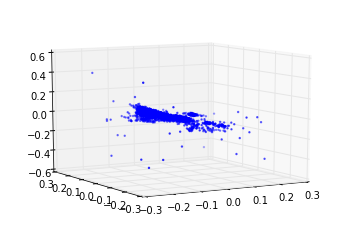

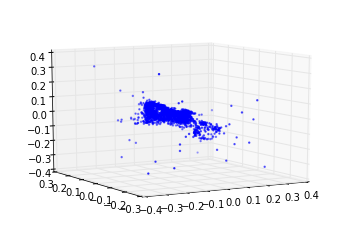

152 (-282287781872.82965, 54959478834365.633) 29.6014831066
153 (-430670326928.11853, 56374098268918.516) 31.0079190731
154 (-297798224858.0741, 57262877500302.219) 31.1576509476
155 (-351648458949.21484, 55233262960033.188) 29.7518107891
156 (-319678666069.33331, 56232700824538.07) 30.2395069599
157 (-369836794159.40741, 56666527163278.219) 31.2331910133
158 (-240272630912.94815, 55040768329500.445) 30.1803021431
159 (-299776600382.57776, 59576876259858.961) 30.3398551941
160 (-524397176179.67407, 57054754116342.516) 31.2676999569
161 (-305844204824.65186, 59296635236200.297) 30.6058950424
INFO:tensorflow:/orions4-zfs/projects/lins2/Jingwei_Space/Git_Repos/tf_lab/notebooks/jingwei/c_10.000000_l_0.001000_/c_10.000000_l_0.001000_models.ckpt-161 is not in all_model_checkpoint_paths. Manually adding it.
162 (-581606146776.17773, 56955710287720.297) 30.5565919876
163 (-274700472350.34073, 57458824353716.148) 31.0787451267
164 (-496990879258.54816, 57330733261103.406) 30.1559619904
165 (-48

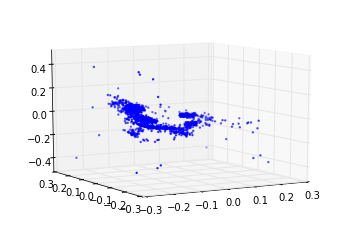

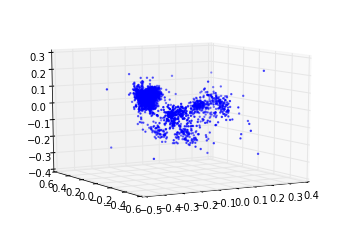

202 (-335684316546.84442, 87244062152021.328) 29.8952710629
203 (-571033549148.91858, 90433985688613.922) 30.5260848999
204 (-356883261030.40002, 89669410672791.703) 31.5262291431
205 (-397766850908.91852, 91166898680263.109) 30.1929810047
206 (-502496074137.59998, 93910563495025.781) 29.6999690533
207 (-609498113031.58521, 94956795345123.562) 31.3581469059
208 (-443313450492.2074, 97097114189824.0) 30.7910320759
209 (-868328550733.74817, 94389037267778.375) 29.7570509911
210 (-581989195472.59265, 94695678794258.969) 30.8761429787
211 (-376583937987.31854, 95725793953564.438) 31.3760390282
212 (-505042917664.23706, 98882242905277.625) 29.8122000694
213 (-383190308545.42224, 95058654173108.141) 30.2527289391
214 (-475927177777.30371, 92497951112609.188) 31.1918148994
215 (-568177694158.69629, 97664322036622.219) 30.359762907
216 (-358238984358.87408, 95528939421696.0) 29.7119750977
217 (-432889579777.8963, 93395808060605.625) 31.1842939854
218 (-677113897506.1333, 94870855920298.672) 31

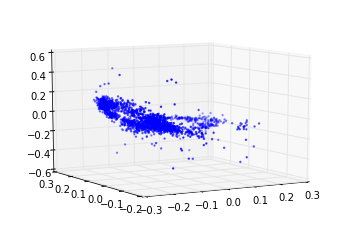

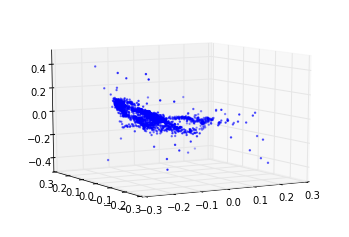

252 (-880049362382.69629, 153388151103184.59) 31.1506938934
253 (-1191385588864.9482, 145480302616272.59) 31.4440231323
254 (-1058862235405.274, 150056095342288.59) 30.2294530869
255 (-1563388601230.2222, 154241427259998.81) 30.4783680439
256 (-1479687443433.2444, 155801047822791.12) 31.4887158871
257 (-1555854139938.1333, 158703254532551.12) 30.847728014
258 (-1107451849143.9407, 158489758245167.41) 30.1338889599
259 (-1389041512417.6592, 153918540417403.25) 31.3583571911
260 (-886543884834.1333, 146834654562683.25) 30.6021170616
261 (-1031241904704.4741, 156085664592933.94) 29.7471148968
262 (-802101795468.32593, 153680894259655.12) 31.3399019241
263 (-1588017554318.2222, 153407999792469.34) 31.3276071548
264 (-1213202742689.1853, 151756876293613.03) 29.7931668758
265 (-1319088972443.4963, 149954024934968.88) 30.9529819489
266 (-1161097556544.4741, 152539254421124.75) 31.2758271694
267 (-884706096165.9259, 151048372597797.94) 30.0397770405
268 (-781144442895.17041, 144597372108800.0)

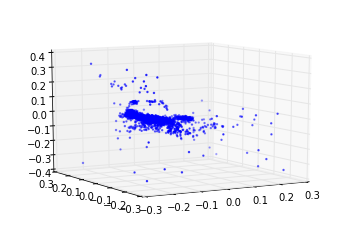

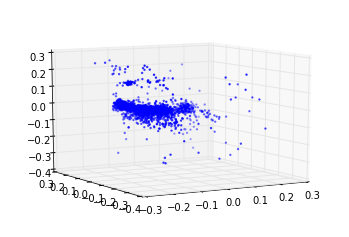

302 (-1130988170505.4814, 204889263643761.78) 30.695638895
303 (-978308172640.71106, 202108453762085.94) 29.5864388943
304 (-1080695420791.4667, 209737929399409.78) 31.4247779846
305 (-951414171117.03699, 204228806787678.81) 31.3246898651
306 (-1060074482468.0297, 216628655748740.75) 29.7688720226
307 (-851319187774.57776, 222397410127720.28) 31.0647609234
308 (-995429135155.19995, 220808964443704.88) 31.0423898697
309 (-1535219904117.5703, 221129021529201.78) 30.041683197
310 (-1127997600684.563, 225073507190556.44) 30.0573050976
311 (-1079407303429.6888, 227441872829250.38) 31.275261879
312 (-989887061469.8667, 228236113069852.44) 30.6849188805
313 (-928069110017.89624, 232942643494305.19) 29.9417829514
314 (-1432196613066.9038, 223072724762017.19) 31.320805788
315 (-1748165028886.7556, 235251178473851.25) 30.951086998
316 (-1672983341374.5779, 250570731538204.44) 29.7020990849
317 (-1467345377689.6001, 251926156605060.75) 31.5837090015
318 (-1471637362369.4221, 254387379784666.06) 3

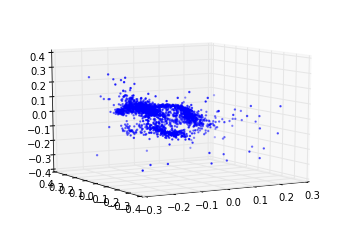

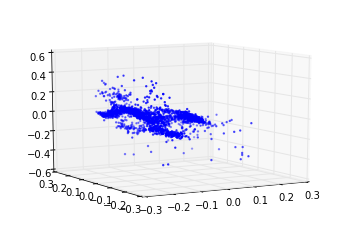

352 (-2110468138477.0371, 265910430310703.41) 31.6299729347
353 (-1933279983479.4666, 254247743637276.44) 31.112626791
354 (-2181898440491.6147, 259827919001524.16) 29.9158008099
355 (-1628062531948.0889, 268925847188517.94) 31.4742689133
356 (-1211654764892.9185, 274276387826346.66) 31.2693781853
357 (-2102183052113.5408, 275369796897147.25) 30.1945569515
358 (-1904359418538.6667, 284604878824941.06) 31.6449098587
359 (-1458090568241.3037, 286216646081953.19) 31.4517760277
360 (-1774908284017.7778, 270699328787797.34) 29.7150061131
361 (-1697662750386.252, 279677815624438.53) 31.3186860085
INFO:tensorflow:/orions4-zfs/projects/lins2/Jingwei_Space/Git_Repos/tf_lab/notebooks/jingwei/c_10.000000_l_0.001000_/c_10.000000_l_0.001000_models.ckpt-361 is not in all_model_checkpoint_paths. Manually adding it.
362 (-1727323252690.4888, 278681962336407.72) 30.091244936
363 (-1986275977655.9407, 266284364007803.25) 29.7568690777
364 (-2069540306458.5481, 267426000739441.78) 31.5946979523
365 (-246

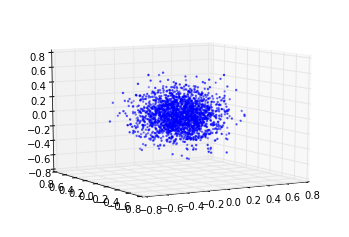

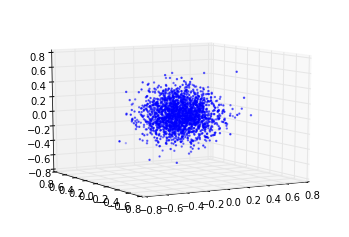

2 (-38.200559411225498, 81.218294638174555) 29.539274931
3 (-135.08982809561272, 344.08444270381221) 31.514108181
4 (-339.74983045789929, 937.65012387876152) 31.6917591095
5 (-729.93796205873844, 2215.8886763961227) 29.9066870213
6 (-1593.5751048900463, 4444.4088812934024) 30.3160231113
7 (-3267.8646158854167, 8350.6932689525456) 31.3462369442
8 (-6238.3217628761577, 15039.431857638889) 30.8256509304
9 (-11059.055700231482, 25813.928096064814) 29.8892638683
10 (-18577.362427662036, 42302.016637731482) 31.4981281757
11 (-29412.72824074074, 65925.778211805562) 31.2656698227
12 (-44709.424826388888, 98732.252025462964) 29.9423968792
13 (-66051.542071759264, 141812.38425925927) 31.4281060696
14 (-94328.56585648148, 200255.39467592593) 31.3810338974
15 (-132534.40925925926, 277252.34837962961) 29.6510448456
16 (-180927.44965277778, 382345.17129629629) 30.4936089516
17 (-238074.72754629629, 511560.00694444444) 31.4463720322
18 (-306862.80208333331, 680668.9444444445) 30.1125540733
19 (-38165

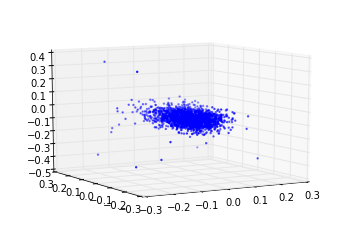

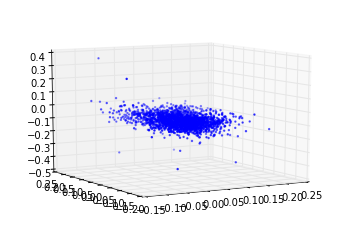

52 (-557818.20370370371, 4185125.7870370368) 30.5526812077
53 (-656816.7111111111, 4711213.111111111) 31.3535377979
54 (-761904.52962962969, 5303297.5370370373) 30.34694314
55 (-890665.34814814816, 5963523.9259259263) 30.5380830765
56 (-1043559.1407407407, 6755431.8148148144) 31.4283509254
57 (-1199091.2962962964, 7454883.7962962966) 30.8494479656
58 (-1392976.4185185186, 8519952.833333334) 30.1687729359
59 (-1599786.174074074, 9826664.222222222) 31.1124179363
60 (-1809606.1703703704, 11018609.777777778) 31.4795198441
61 (-2031116.888888889, 11856803.481481481) 30.0057051182
62 (-2245749.4074074072, 13672736.296296297) 31.3463959694
63 (-2485882.5925925928, 15462425.703703703) 31.3029651642
64 (-2711049.8370370371, 17701083.888888888) 29.860063076
65 (-2954734.8370370371, 19461085.037037037) 30.7945170403
66 (-3177990.3851851854, 21889659.925925925) 31.3345429897
67 (-3335550.2814814816, 24717010.370370369) 30.218708992
68 (-3335093.6592592592, 27220412.222222224) 30.3848202229
69 (-32

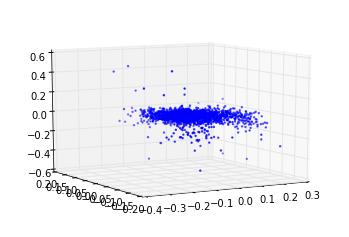

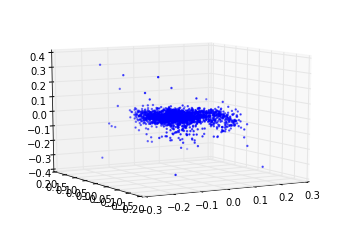

102 (-13139786.429629629, 289072881.77777779) 30.6587920189
103 (-13894096.355555555, 296306436.74074072) 30.0414228439
104 (-16891270.162962962, 322298157.03703701) 31.1833021641
105 (-23914073.600000001, 356455408.5925926) 31.1607999802
106 (-33738749.866666667, 399070723.55555558) 29.6254711151
107 (-30609563.733333334, 449304662.51851851) 30.5859320164
108 (-22559700.148148149, 472835298.37037039) 31.1792509556
109 (-21864447.762962963, 498946966.51851851) 29.9592452049
110 (-19402649.600000001, 490532114.96296299) 29.7731089592
111 (-15601770.903703704, 477489021.62962961) 31.297991991
112 (-12448638.814814815, 458969947.25925928) 31.2159819603
113 (-10982110.103703704, 458670418.96296299) 29.5278019905
114 (-12768303.17037037, 452897528.8888889) 30.5356478691
115 (-14205735.822222222, 473202613.33333331) 30.5211949348
116 (-17837504.474074073, 473823759.4074074) 30.3805248737
117 (-20194713.362962961, 471130313.48148149) 29.8163430691
118 (-22957419.614814814, 506349522.96296299)

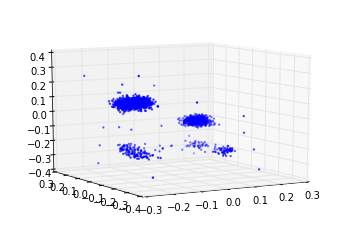

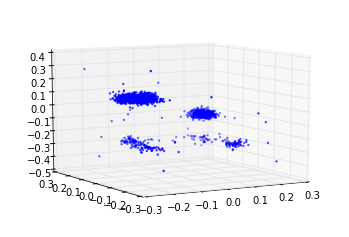

152 (-19626838.281481482, 845388247.70370376) 30.2743330002
153 (-21322777.125925925, 842119087.4074074) 30.4077391624
154 (-19513065.244444445, 700409685.33333337) 31.35780406
155 (-25462826.666666668, 962018157.03703701) 30.7849490643
156 (-29676047.88148148, 662224464.5925926) 29.7141690254
157 (-8751062.2814814821, 692793095.11111116) 31.3571798801
158 (-30286708.148148149, 1000605963.8518518) 31.2742569447
159 (-18950792.533333335, 731513618.96296299) 29.8835980892
160 (-15360375.94074074, 755636385.18518519) 30.7385258675
161 (-7989101.0370370373, 938037584.5925926) 31.3310461044
INFO:tensorflow:/orions4-zfs/projects/lins2/Jingwei_Space/Git_Repos/tf_lab/notebooks/jingwei/c_10.000000_l_0.000100_/c_10.000000_l_0.000100_models.ckpt-161 is not in all_model_checkpoint_paths. Manually adding it.
162 (-36085946.785185188, 584060146.96296299) 29.5909039974
163 (-8919647.7629629634, 598966042.07407403) 31.6647090912
164 (-3740553.4814814813, 862663450.07407403) 31.4917728901
165 (-2091300

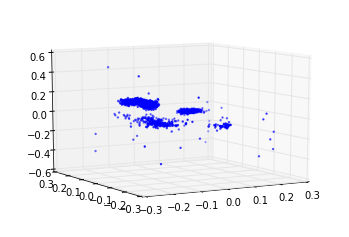

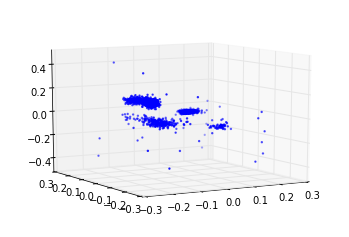

202 (-11610983.348148149, 1000562782.8148148) 31.1426789761
203 (-17227331.792592593, 1024418669.037037) 31.3649320602
204 (-15856248.414814815, 993333195.85185182) 29.7724897861
205 (-19047719.348148149, 1030768794.074074) 31.6413679123
206 (-20098493.629629631, 1078085501.6296296) 31.2963130474
207 (-20993445.925925925, 1113023755.8518519) 29.6134469509
208 (-23332115.437037036, 1093458045.6296296) 30.4194550514
209 (-31364815.644444443, 1098616507.2592592) 31.4133360386
210 (-33001844.622222222, 1181068122.074074) 30.5236110687
211 (-13810842.074074075, 1140980551.1111112) 29.7447299957
212 (-20448684.088888887, 1141632564.1481481) 31.4019851685
213 (-22424549.451851852, 1137638805.3333333) 31.1667459011
214 (-17257156.740740743, 1117826564.7407408) 30.0059587955
215 (-16676826.074074075, 1137215345.7777777) 32.2464079857
216 (-17439963.496296298, 1151018851.5555556) 31.1198198795
217 (-19638956.562962964, 1139830976.0) 29.8200769424
218 (-18418436.266666666, 1191769633.1851852) 31.

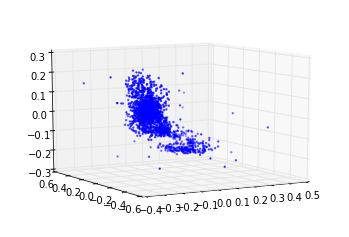

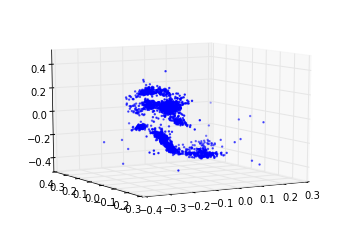

252 (-24234384.11851852, 1377455981.0370371) 29.851047039
253 (-30602022.874074075, 1367909518.2222223) 30.7595078945
254 (-27193242.548148148, 1404426481.7777777) 31.5694711208
255 (-26463526.874074075, 1441132970.6666667) 30.3809049129
256 (-31775669.096296296, 1398395970.3703704) 30.4691569805
257 (-28585413.214814816, 1440919931.2592592) 31.8093090057
258 (-21756002.607407406, 1401878499.5555556) 30.6875610352
259 (-28880447.525925927, 1422647954.9629629) 30.9207639694
260 (-35262646.992592596, 1305287130.074074) 31.4553821087
261 (-38241522.725925922, 1383527215.4074075) 30.7555289268
262 (-25340704.71111111, 1232552146.9629629) 30.1417038441
263 (-26386977.185185187, 1381746759.1111112) 31.4630219936
264 (-26381765.214814816, 1447983928.8888888) 31.4265038967
265 (-30890924.562962964, 1446813610.6666667) 29.8621518612
266 (-34718872.651851855, 1466104229.925926) 31.2733860016
267 (-36968348.444444448, 1445521536.0) 31.2419950962
268 (-38612704.711111113, 1461337965.0370371) 29.54

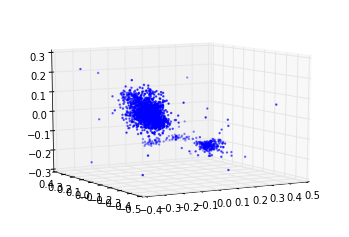

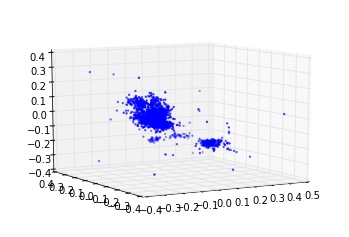

302 (-24441447.348148149, 2113434998.5185184) 31.134141922
303 (-28655889.066666666, 2077233611.8518519) 29.6060369015
304 (-30042009.600000001, 2055486392.8888888) 31.570595026
305 (-31617406.103703704, 1982803095.7037036) 31.4540638924
306 (-30677566.577777777, 2087042450.9629629) 29.7631621361
307 (-30385930.429629631, 2050006684.4444444) 30.7968270779
308 (-29143779.555555556, 1999607485.6296296) 31.2792649269
309 (-28417550.222222224, 2122694641.7777777) 30.2164521217
310 (-25362413.037037037, 2177860461.0370369) 30.2833988667
311 (-31841563.496296298, 2234628631.7037039) 31.5175871849
312 (-40042398.34074074, 2265608500.1481481) 30.7232830524
313 (-31072994.607407406, 2275643429.9259257) 29.6279268265
314 (-28549924.029629629, 2336284453.9259257) 31.2608158588
315 (-32000512.0, 2292175293.6296296) 31.4973750114
316 (-29909423.407407407, 2325857422.2222223) 29.8631329536
317 (-27817919.525925927, 2318562275.5555553) 31.3520040512
318 (-32261005.274074074, 2357257045.3333335) 31.45

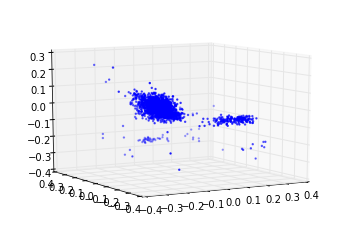

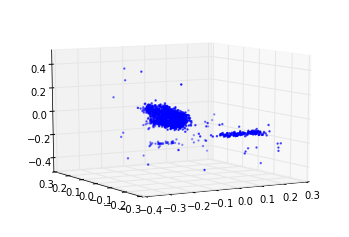

352 (-27434357.570370369, 2975769144.8888888) 30.8828511238
353 (-32287789.51111111, 2942768213.3333335) 31.279984951
354 (-30862387.199999999, 2884780354.3703704) 30.2131640911
355 (-24345423.644444443, 3059649801.4814816) 30.3765468597
356 (-33571659.851851851, 3006379576.8888888) 31.6512160301
357 (-35428719.881481484, 2984140856.8888888) 30.3416409492
358 (-29086001.303703703, 3107112997.9259257) 30.5832650661
359 (-33816056.414814815, 3194511625.4814816) 31.547326088
360 (-34151826.014814816, 3042772347.2592592) 30.7861549854
361 (-30308721.777777776, 3180225867.8518519) 29.9469850063
INFO:tensorflow:/orions4-zfs/projects/lins2/Jingwei_Space/Git_Repos/tf_lab/notebooks/jingwei/c_10.000000_l_0.000100_/c_10.000000_l_0.000100_models.ckpt-361 is not in all_model_checkpoint_paths. Manually adding it.
362 (-30225005.985185184, 3192243418.0740743) 31.4656949043
363 (-35755834.785185188, 3135064149.3333335) 30.3046469688
364 (-34555352.177777775, 3087043498.6666665) 31.0635130405
365 (-389

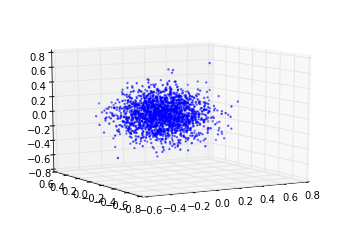

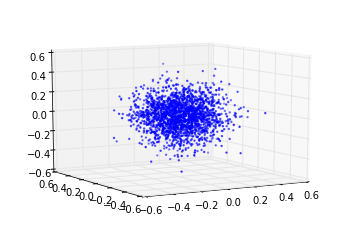

2 (-1.3213100256743255, 2.9042767109694303) 29.5261001587
3 (-2.6505192668349653, 5.6600297115467209) 32.1292791367
4 (-4.0726718708320897, 8.9027614593505859) 31.0337409973
5 (-5.4061534104523838, 12.393386522928873) 30.0869739056
6 (-6.6584106233384874, 16.32719205926966) 31.220359087
7 (-7.9873402418913662, 20.856808909663446) 32.1725609303
8 (-9.3377562063711661, 26.080010449444806) 29.8971920013
9 (-11.015348844174985, 32.085030379118741) 30.7929980755
10 (-12.839432765819408, 38.972347965946902) 31.1892230511
11 (-14.89986555311415, 46.337736482973455) 29.7116408348
12 (-17.449419911702474, 54.742479677553533) 30.1989428997
13 (-20.491061627423321, 63.90069551821108) 31.0755710602
14 (-23.702121084707755, 74.432929427535441) 30.9673171043
15 (-27.432161684389467, 85.929788094979742) 29.4349608421
16 (-31.866494722719544, 97.557721173321752) 31.0269579887
17 (-36.713110973216871, 111.39912188494647) 31.1860339642
18 (-42.262631790726275, 125.83775583902995) 29.7677280903
19 (-48.9

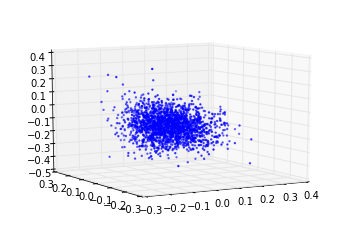

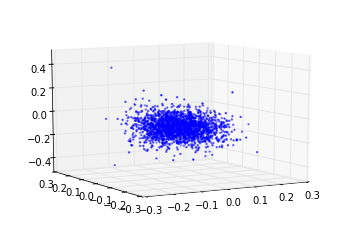

52 (-748.43056098090278, 3029.7057924623841) 21.4802079201
53 (-794.53567165798609, 3274.3695836950233) 21.419727087
54 (-817.75288628472219, 3466.6648853443289) 21.6920859814
55 (-863.52760597511576, 3665.5420283564813) 21.4912319183
56 (-901.68330258969911, 3900.8442654079863) 21.7619481087
57 (-950.41808087384254, 4099.5931893807874) 21.5090348721
58 (-995.0362431278935, 4313.5413321035876) 21.638767004
59 (-1041.6487485532407, 4536.0028573495374) 21.566193819
60 (-1085.8844111689814, 4770.0721752025465) 21.626969099
61 (-1143.6201859085647, 5025.9959852430557) 21.5014548302
62 (-1188.8537254050925, 5234.4992766203704) 21.5143768787
63 (-1233.771728515625, 5437.7156213831022) 21.5502521992
64 (-1290.1280526620371, 5663.3010525173613) 21.5603749752
65 (-1352.1240813078705, 5929.4816984953704) 21.5629451275
66 (-1410.4356951678242, 6167.0429144965274) 21.6204619408
67 (-1482.3526837384259, 6349.6758716724535) 21.5020961761
68 (-1539.6347005208333, 6566.5744176793978) 21.5875480175
69 

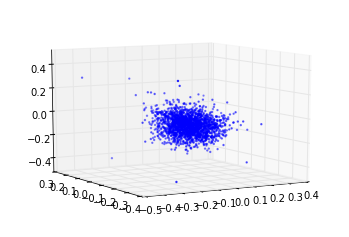

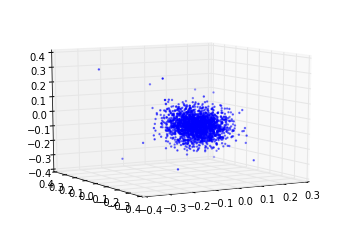

102 (-11883.251902488426, 21656.408420138891) 21.6262819767
103 (-12367.024428530092, 22195.15625) 21.6733148098
104 (-13000.278233506944, 22847.885633680555) 21.6675782204
105 (-13732.646867766203, 23741.690538194445) 21.5987889767
106 (-14627.017773437499, 24885.712673611109) 21.6904001236
107 (-15793.240878182871, 26471.637586805555) 21.6163270473
108 (-17036.405092592591, 27873.218967013891) 21.7000000477
109 (-18227.390154803241, 29274.414279513891) 21.4768211842
110 (-19263.508441840277, 30186.438295717591) 21.5755720139
111 (-19764.381749131946, 30695.36299189815) 21.6986851692
112 (-19822.088831018518, 31387.239583333332) 21.5249738693
113 (-19917.719661458334, 32647.005497685186) 21.6079280376
114 (-19990.976591435185, 34438.691261574073) 21.5154461861
115 (-20374.119719328704, 36262.217881944445) 21.6038379669
116 (-21107.762774884261, 38230.696469907409) 21.5182878971
117 (-21837.495616319444, 40260.791811342591) 21.4532461166
118 (-22819.106973379628, 41785.575954861109) 21

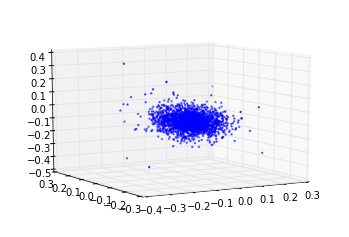

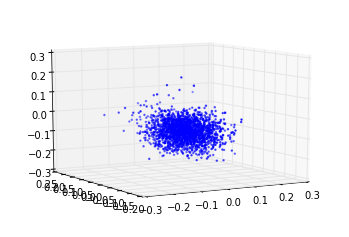

152 (-63860.211342592593, 150950.81770833334) 21.4133520126
153 (-64725.890104166669, 153574.7789351852) 21.3256671429
154 (-66502.796585648146, 156943.26215277778) 21.3297960758
155 (-67413.287557870368, 161775.6695601852) 21.3731021881
156 (-68848.035011574073, 167165.52546296295) 21.3536369801
157 (-69829.036168981474, 171147.94444444444) 21.3544559479
158 (-71083.638194444444, 176579.98784722222) 21.3635530472
159 (-71946.938425925924, 183406.2991898148) 21.3270411491
160 (-73420.37262731482, 189284.87442129629) 21.3247368336
161 (-74725.712037037039, 196072.51851851851) 21.3242759705
INFO:tensorflow:/orions4-zfs/projects/lins2/Jingwei_Space/Git_Repos/tf_lab/notebooks/jingwei/c_10.000000_l_0.000010_/c_10.000000_l_0.000010_models.ckpt-161 is not in all_model_checkpoint_paths. Manually adding it.
162 (-75197.195196759261, 201853.63599537036) 21.328963995
163 (-76100.490740740745, 208409.16319444444) 21.2919209003
164 (-77433.505497685182, 215212.0335648148) 21.3424839973
165 (-78468.

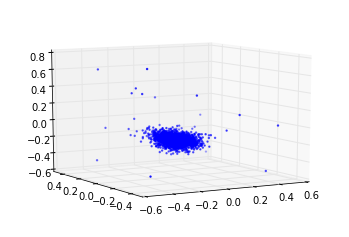

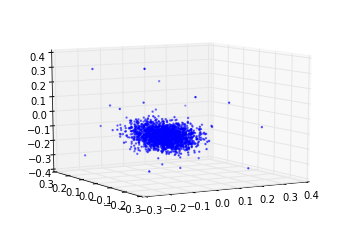

202 (-41647.438657407409, 466766.43402777775) 21.3785190582
203 (-38070.573842592596, 462049.42476851854) 21.2882728577
204 (-36220.451157407406, 467230.97337962961) 21.3728499413
205 (-34197.478009259263, 465781.05787037039) 21.3458530903
206 (-25826.181944444445, 469863.25925925927) 21.2997441292
207 (-25085.219907407409, 443760.07754629629) 21.3091368675
208 (-17691.96875, 449519.22916666669) 21.3001978397
209 (-15847.613888888889, 451658.39814814815) 21.4115259647
210 (-16433.290277777778, 446877.85416666669) 21.3631629944
211 (-13392.942824074074, 438343.64120370371) 21.3726701736
212 (-4266.5583333333334, 426194.82870370371) 21.3781831264
213 (-9466.8766203703708, 423956.56828703702) 21.3606469631
214 (4731.9643518518515, 414509.79050925927) 21.3585131168
215 (1185.0935185185185, 404540.72106481483) 21.3216779232
216 (2447.5722222222221, 387256.26504629629) 21.3908760548
217 (6014.6418981481484, 380265.35300925927) 21.3242638111
218 (5362.9935185185186, 359231.17824074073) 21.376

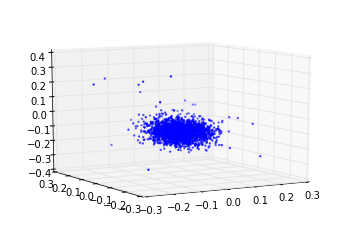

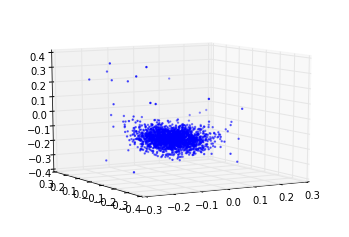

252 (-16637.450000000001, 86456.527488425927) 21.3353850842
253 (-16767.850694444445, 85806.546006944438) 21.3523440361
254 (-16612.278530092593, 81884.953993055562) 21.4094409943
255 (-16886.884953703702, 77339.777777777781) 21.408987999
256 (-17075.00920138889, 77573.545138888891) 21.3142669201
257 (-17276.355353009258, 73279.760995370365) 21.3572900295
258 (-17714.927777777779, 73121.692708333328) 21.3405971527
259 (-17830.707638888889, 71730.561053240745) 21.3231329918
260 (-18025.84904513889, 73828.4765625) 21.3080370426
261 (-18348.776996527777, 74776.594907407401) 21.3555998802
262 (-18573.077488425926, 79132.8203125) 21.3514070511
263 (-18808.050144675926, 83340.125289351854) 21.2965149879
264 (-19050.077546296296, 86326.442129629635) 21.2709138393
265 (-19297.651620370369, 90348.336226851854) 21.2975211143
266 (-19514.810127314813, 94262.451678240745) 21.3381979465
267 (-19670.485879629628, 95264.100983796292) 21.3421938419
268 (-19932.605787037039, 96936.471354166672) 21.3627

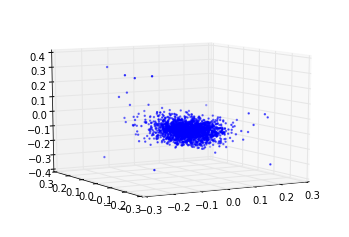

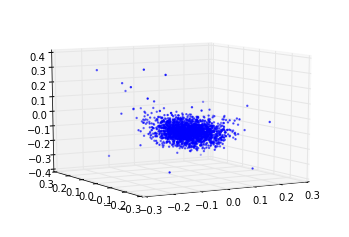

302 (-36885.882291666669, 215801.95601851851) 21.440969944
303 (-38261.638541666667, 226099.89930555556) 21.3718760014
304 (-38312.678124999999, 229013.73379629629) 21.3718509674
305 (-39354.124421296299, 232763.61226851851) 21.3826510906
306 (-40408.482638888891, 237738.53414351851) 21.465031147
307 (-41475.950462962966, 239240.89120370371) 21.3690099716
308 (-42505.075115740743, 244057.65625) 21.4169728756
309 (-43701.57916666667, 248382.7679398148) 21.5119578838
310 (-44509.188078703701, 250815.16840277778) 21.4915149212
311 (-45297.018518518518, 257895.60879629629) 21.4657659531
312 (-46708.676736111112, 266813.734375) 21.4459950924
313 (-47782.093865740739, 275901.68402777775) 21.4029200077
314 (-49388.17696759259, 286189.4571759259) 21.3281180859
315 (-50408.634259259263, 288249.5428240741) 21.3491859436
316 (-51609.341550925928, 293075.26620370371) 21.3998968601
317 (-52936.799305555556, 298561.93981481483) 21.4267988205
318 (-54223.023726851854, 303193.48611111112) 21.435523986

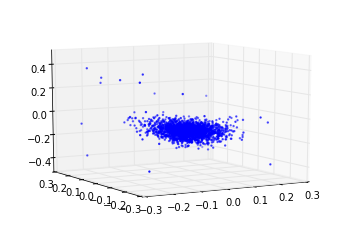

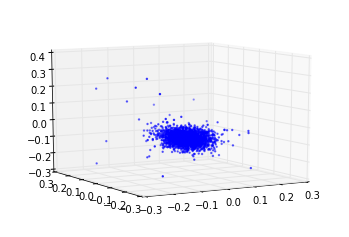

352 (-123811.50254629629, 652421.13888888888) 21.4895710945
353 (-127369.51018518518, 665961.1875) 21.5026659966
354 (-130028.74953703703, 678128.0069444445) 21.4570438862
355 (-133509.51666666666, 690220.60648148146) 21.4452900887
356 (-136974.72824074075, 705641.33101851854) 21.4379320145
357 (-140466.38981481481, 710469.54398148146) 21.4653949738
358 (-143261.21527777778, 724874.66666666663) 21.4322228432
359 (-146977.15231481483, 738284.7569444445) 21.5274379253
360 (-150735.72129629631, 755202.375) 21.5217652321
361 (-153239.17685185187, 763723.29166666663) 21.3930621147
INFO:tensorflow:/orions4-zfs/projects/lins2/Jingwei_Space/Git_Repos/tf_lab/notebooks/jingwei/c_10.000000_l_0.000010_/c_10.000000_l_0.000010_models.ckpt-361 is not in all_model_checkpoint_paths. Manually adding it.
362 (-157495.67037037038, 769868.97916666663) 21.3844978809
363 (-160855.38888888888, 775021.04629629629) 21.3327829838
364 (-164958.33055555556, 781698.90972222225) 21.5276970863
365 (-168746.3060185185

In [8]:
dump_dir = '/orions4-zfs/projects/lins2/Jingwei_Space/Git_Repos/tf_lab/notebooks/jingwei'
for clamp in clamp_list:
    for init_lr in init_lr_list:
        print '*==== STARTING: clamp: %f, init_lr: %f' % (clamp, init_lr)
        reset_tf_graph()
        gan = RawWGAN(experiment_name, [n_pc_samples, 3], learning_rate=init_lr, clamp=clamp)
        if do_training:
            train_stats = []
            dump_subdir = osp.join(dump_dir, 'c_%f_l_%f_' % (clamp, init_lr))
            if not osp.exists(dump_subdir):
                os.makedirs(dump_subdir)
            for iter in range(max_epochs):
                checkpoint_path = osp.join(dump_subdir, 'c_%f_l_%f_' % (clamp, init_lr) + model_saver_id)
                loss, duration = gan._single_epoch_train(train_data, batch_size, noise_params)
                epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
                print epoch, loss, duration
                if save_model:
                    if iter % 40 == 0 or iter == max_epochs - 1:
                        gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
                train_stats.append((epoch,) + loss)
                if iter % 50 == 0:
                    Point_Cloud(gan.generate(1, noise_params)[0]).plot()
                    Point_Cloud(gan.generate(1, noise_params)[0]).plot()

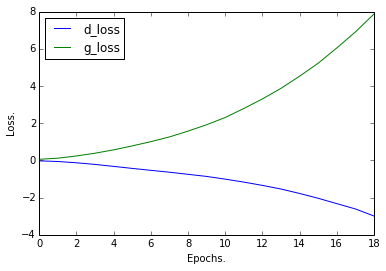

In [8]:
if do_plotting:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss)
    plt.plot(x, g_loss)
    plt.legend(['d_loss', 'g_loss'], loc=0)
    plt.xlabel('Epochs.')
    plt.ylabel('Loss.')

In [9]:
if save_synthetics_sample:
    # Swap axis and put in U-sphere and save
    n_samples = 1000
    syn_data = gan.generate(n_samples, noise_params)
    syn_data_rot = np.empty_like(syn_data)
    for i, pc in enumerate(syn_data):
        syn_data_rot[i] = pc[:, [0, 2, 1]]
        pc = Point_Cloud(syn_data_rot[i]).center_in_unit_sphere()
        syn_data_rot[i] = pc.points
        
    save_out = osp.join(synthetic_data_out_dir, experiment_name + '_epoch_' + str(epoch))
    np.savez(save_out, syn_data_rot)

In [10]:
from tf_lab.nips.evaluate_gan import entropy_of_occupancy_grid
print entropy_of_occupancy_grid(syn_data, 32)

NameError: name 'syn_data' is not defined

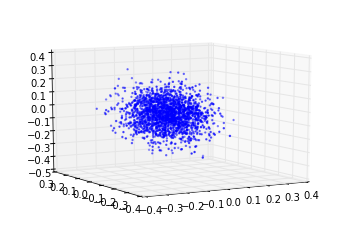

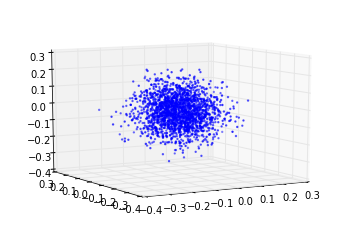

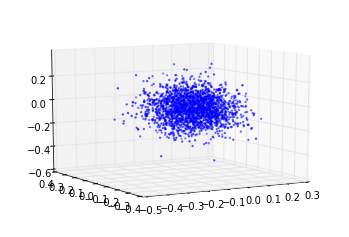

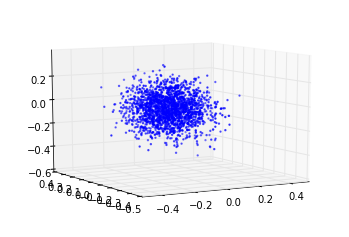

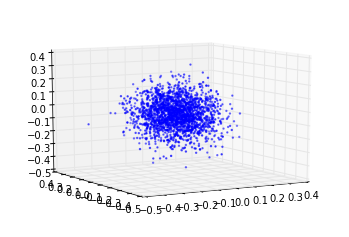

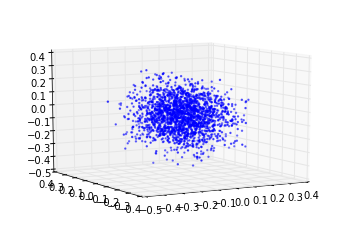

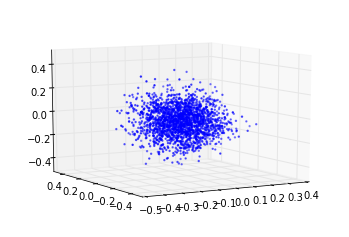

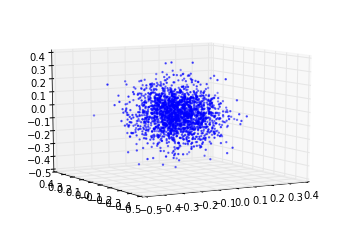

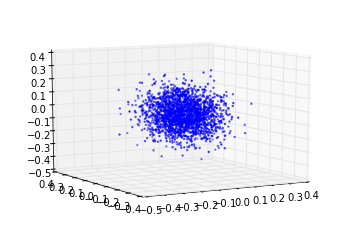

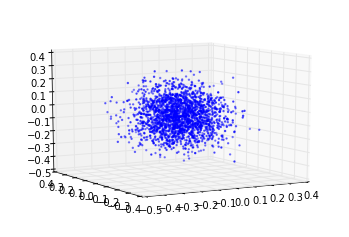

In [13]:
for i in range(10):
    Point_Cloud(gan.generate(1, noise_params)[0]).plot()